In [91]:
import os

from langchain_core.messages import HumanMessage
from langchain_openai import AzureChatOpenAI
from langchain_community.vectorstores.azuresearch import AzureSearch

os.environ["OPENAI_API_VERSION"] = "2024-02-15-preview"
os.environ["AZURE_OPENAI_ENDPOINT"] = "https://openaimodelv3si.openai.azure.com/"
os.environ["AZURE_OPENAI_API_KEY"] = "e248b8e8dbf94849ac6888971cacc9ae"

In [92]:
llm = AzureChatOpenAI(
    openai_api_version="2023-05-15",
    azure_deployment="trial1",
)

In [93]:
message = HumanMessage(
    content="Translate this sentence from English to French. I love programming."
)
llm.invoke([message])

AIMessage(content="J'adore la programmation.", response_metadata={'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {}})

In [ ]:
# from langchain_community.document_loaders import PyPDFLoader

# loader = PyPDFLoader("/home/chandan/orange/code/2021-annual-report.pdf")
# pages = loader.load_and_split()
# pages

In [95]:
# from langchain_openai import OpenAIEmbeddings
# embeddings = OpenAIEmbeddings()

from langchain_openai import AzureOpenAIEmbeddings
from langchain_community.vectorstores import FAISS

embeddings = AzureOpenAIEmbeddings(
    azure_deployment="embed1",
    openai_api_version=os.getenv("OPENAI_API_VERSION"),
)
# vector = FAISS.from_documents(pages, embeddings)
# retriever = vector.as_retriever()

os.environ["AZURE_SEARCH_ENDPOINT"] = "https://esg-demo.search.windows.net"
os.environ["AZURE_SEARCH_KEY"] = "m0NJknRuJEIMMLWeYheHYAUBafnvlIuap48eNQuHI2AzSeAQpZND"

index_name: str = "esg-demo-all"
vector_all: AzureSearch = AzureSearch(
    azure_search_endpoint=os.getenv("AZURE_SEARCH_ENDPOINT"),
    azure_search_key=os.getenv("AZURE_SEARCH_KEY"),
    index_name=index_name,
    embedding_function=embeddings.embed_query,
)

index_name: str = "esg-demo-2021"
vector_2021: AzureSearch = AzureSearch(
    azure_search_endpoint="https://esg-demo.search.windows.net",
    azure_search_key="m0NJknRuJEIMMLWeYheHYAUBafnvlIuap48eNQuHI2AzSeAQpZND",
    index_name=index_name,
    embedding_function=embeddings.embed_query,
)
index_name: str = "esg-demo-2022"
vector_2022: AzureSearch = AzureSearch(
    azure_search_endpoint="https://esg-demo.search.windows.net",
    azure_search_key="m0NJknRuJEIMMLWeYheHYAUBafnvlIuap48eNQuHI2AzSeAQpZND",
    index_name=index_name,
    embedding_function=embeddings.embed_query,
)
index_name: str = "esg-demo-2023"
vector_2023: AzureSearch = AzureSearch(
    azure_search_endpoint="https://esg-demo.search.windows.net",
    azure_search_key="m0NJknRuJEIMMLWeYheHYAUBafnvlIuap48eNQuHI2AzSeAQpZND",
    index_name=index_name,
    embedding_function=embeddings.embed_query,
)

retriever = vector_2021.as_retriever()

In [105]:
from langchain.chains import RetrievalQA
from langchain.prompts import (
    PromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
    ChatPromptTemplate,
)

# review_template = """Your job is to use environmental, social and governance (ESG) 
# documents and annual reports to answer questions. Use
# the following context to answer questions. Be as detailed as possible, but
# don't make up any information that's not from the context. If you don't know
# an answer, say you don't know. 
# ***Most Important: When providing tables in response, strictly ensure to adhere following format(No plaintext, csv, json, yaml or anything else): Table it should be organized such that each row of the table corresponds to a list within a list, with each element representing a column. Put a newline character after each list.***
# {context}
# """

review_template = """Your job is to use environmental, social and governance (ESG) 
documents and annual reports to answer questions. Use
the following context to answer questions. Be as detailed as possible, but
don't make up any information that's not from the context. If you don't know
an answer, say you don't know.
{context}
"""

esg_system_prompt = SystemMessagePromptTemplate(
    prompt=PromptTemplate(input_variables=["context"], template=review_template)
)

# esg_human_prompt = HumanMessagePromptTemplate(
#     prompt=PromptTemplate(input_variables=["question"], template="Answer the question: '{question}' by filling the None in the table: ['Start date', 'End date', 'Indicate if you are providing emissions data for past reporting years', 'Select the number of past reporting years you will be providing Scope 2 emissions data for*', 'Select the number of past reporting years you will be providing Scope 2 emissions data for*', 'Select the number of past reporting years you will be providing Scope 3 emissions data for*'][None, None, None, None, None, None] where list is a row of the table")
# )
# esg_human_prompt = HumanMessagePromptTemplate(
#     prompt=PromptTemplate(input_variables=["question"], template="{question}.\n Answer according to the response format provided. The table(if provided) in the response options is passed as list of columns and each list is a rows. Rows are divided by newline. Merge them with contextual meaning and then fill the table")
# )
esg_human_prompt = HumanMessagePromptTemplate(
    prompt=PromptTemplate(input_variables=["question"], template="Answer the given question according to the response-option strictly and keep it concise if provided: {question}")
)
# esg_human_prompt = HumanMessagePromptTemplate(
#     prompt=PromptTemplate(input_variables=["question"], template="{question}.\n Answer according to the response format provided. The table(if provided) in the response options is passed as list of columns comma separated columns. Rows are divided by newline.")
# )
# esg_human_prompt = HumanMessagePromptTemplate(
#     prompt=PromptTemplate(input_variables=["question"], template="{question}.\n Answer according to the response format provided. The table(if provided) in the response options is passed as list of columns comma separated columns. Rows are divided by newline. When you're returning a table, please mention it by flag 'Table:'")
# )
messages = [esg_system_prompt, esg_human_prompt]

esg_prompt = ChatPromptTemplate(
    input_variables=["context", "question"], messages=messages
)

esg_vector_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever,
    return_source_documents=True
)
esg_vector_chain.combine_documents_chain.llm_chain.prompt = esg_prompt

In [107]:
# query = "State the start and end date of the year for which you are reporting data and indicate whether you will be providing emissions data for past reporting years."
query = "(C0.2) State the start and end date of the year for which you are reporting data and indicate whether you will be providing emissions data for past reporting years.\nConnection to other frameworks RE100\nResponse options\nPlease complete the following table. * Column/row appearance is dependent on selections in this or other questions.\n['Start date', 'End date', 'Indicate if you are providing', 'Select the number of past', 'Select the number of past', 'Select the number of past']\n['', '', 'emissions data for past', 'reporting years you will be', 'reporting years you will be', 'reporting years you will be']\n['', 'None', 'reporting years', 'providing Scope 1 emissions data for*', 'providing Scope 2 emissions data for*', 'providing Scope 3 emissions data for*']\n['From: [DD/MM/YYYY]', 'To: [DD/MM/YYYY]', 'Select from:', 'Select from:', 'Select from:', 'Select from:']\n['', '', '● Yes', '● 1 year', '● 1 year', ':selected: ● 1 year']\n['', '', ':selected: ● No', '· 2 years', '● 2 years', '· 2 years']\n['', '', '', '· 3 years', '● 3 years', '· 3 years']\n['', '', '', '● 4 years', '● 4 years', '· 4 years']\n['', '', '', '● 5 years', '● 5 years', '● 5 years']\n['', '', '', '● Not providing past', '● Not providing past', '● Not providing past']\n['None', 'None', '', 'emissions data for', 'emissions data for', 'emissions data for']\n['None', 'None', '', 'Scope 1', 'Scope 2', 'Scope 3']"
# query = "(C-FS0.7) Which activities does your organization undertake, and which industry sectors does your organization lend to, invest in, and/orinsure? Question dependencies This question is mandatory, and your response to it determines which questions will be shown throughout the questionnaire and which response options will be presented within these questions. If no selection is made in column 4, the FW-FS module will not appear. Minor change\n Connection to other frameworks\n TCFD\n Financial Sector\n Response options\nPlease complete the following table: (*column/row appearance is dependent on selections in this or other questions)\n\nActivity,Does your organization undertake this activity?,Insurance types underwritten*,Industry sectors your organization lends to, invests in, and/or insures*\nBanking (Bank),Select from:,Select all that apply:,See drop-down options below\nNone,:selected: ● Yes,· General (non-life),\nNone,:selected: ● No,· Life and/or Health,\nInvesting (Asset manager),,,\nInvesting (Asset owner),,,\nInsurance underwriting (Insurance company),,,"
response = esg_vector_chain.invoke(query)
response

{'query': "(C0.2) State the start and end date of the year for which you are reporting data and indicate whether you will be providing emissions data for past reporting years.\nConnection to other frameworks RE100\nResponse options\nPlease complete the following table. * Column/row appearance is dependent on selections in this or other questions.\n['Start date', 'End date', 'Indicate if you are providing', 'Select the number of past', 'Select the number of past', 'Select the number of past']\n['', '', 'emissions data for past', 'reporting years you will be', 'reporting years you will be', 'reporting years you will be']\n['', 'None', 'reporting years', 'providing Scope 1 emissions data for*', 'providing Scope 2 emissions data for*', 'providing Scope 3 emissions data for*']\n['From: [DD/MM/YYYY]', 'To: [DD/MM/YYYY]', 'Select from:', 'Select from:', 'Select from:', 'Select from:']\n['', '', '● Yes', '● 1 year', '● 1 year', ':selected: ● 1 year']\n['', '', ':selected: ● No', '· 2 years', '

In [108]:
import os
import re
from azure.ai.formrecognizer import DocumentAnalysisClient
from azure.core.credentials import AzureKeyCredential

endpoint = "https://team-orange.cognitiveservices.azure.com/"
key = "6c106509d1c34958aeb7fff48c806a5a"

class Table:
    def __init__(self, rows, columns, default_value=""):
        self.rows = rows
        self.columns = columns
        self.table = [[default_value for _ in range(columns)] for _ in range(rows)]

    def get_value(self, row, column):
        return self.table[row][column]

    def set_value(self, row, column, value):
        self.table[row][column] = value

    def get_table(self):
        strTable = ""
        for row in self.table:
            strTable += str(row) + ","
        return strTable

    def print_table(self):
        for row in self.table:
            print(row)

def find_matching_texts(text):
    regex_pattern = r"(?s)\((C(?:-FS)?\d+(?:\.\d+)?[a-z]?)\)(.*?)(?=\((C(?:-FS)?\d+(?:\.\d+)?[a-z]?)\)|$)"
    matches = re.findall(regex_pattern, text)

    result_dict = {}

    for match in matches:
        start_pattern, captured_text, end_pattern = match
        result_dict[start_pattern] = captured_text.strip()

    all_c_patterns = re.findall(r"(?s)\((C(?:-FS)?\d+(?:\.\d+)?[a-z]?)\)", text)

    for c_pattern in all_c_patterns:
        if c_pattern not in result_dict:
            result_dict[c_pattern] = ""

    return result_dict

tables = {}
tablecells = {}
print_table = {}

def analyze_layout():
    pdf_path = "/home/chandan/orange/code/Survey-Questionnire-Part1.pdf"

    with open(pdf_path, "rb") as pdf_file:
        pdf_content = pdf_file.read()

    document_analysis_client = DocumentAnalysisClient(
        endpoint=endpoint, credential=AzureKeyCredential(key)
    )
    poller = document_analysis_client.begin_analyze_document(
        "prebuilt-layout", pdf_content
    )
    result = poller.result()
    data = ""
    for table_idx, table in enumerate(result.tables):
        mytable = Table(table.row_count, table.column_count)
        for cell in table.cells:
            mytable.set_value(cell.row_index, cell.column_index, cell.content)
            if len(cell.spans) == 0:
                continue
            tablecells[cell.spans[0].offset] = table_idx
        tables[table_idx] = mytable
        print_table[table_idx] = False
    
    for element in result.paragraphs:
        if len(element.spans) == 0:
            continue
        item = tablecells.get(element.spans[0].offset)
        if item is not None:
            if print_table[item] == False:
                data += tables[item].get_table() + "\n"
                print_table[item] = True
        else:
            # print(element.content)
            if element.content.startswith("Page"):
                continue
            data += str(element.content) + "\n"
    
    return data

que = find_matching_texts(analyze_layout())

In [109]:
query = que["C0.1"]
print(query)
response = esg_vector_chain.invoke(query)
response

Give a general description and introduction to your organization.
Response options
This is an open text question with a limit of 5,000 characters. Please note that when copying from another document into the ORS, formatting is not retained.
CDP DISCLOSURE INSIGHT ACTION


{'query': 'Give a general description and introduction to your organization.\nResponse options\nThis is an open text question with a limit of 5,000 characters. Please note that when copying from another document into the ORS, formatting is not retained.\nCDP DISCLOSURE INSIGHT ACTION',
 'result': 'Wells Fargo & Company is a financial institution with a strategic focus on technology-driven banking services. The company is transitioning towards an API-driven architecture to enhance customer experience and expedite product development. Additionally, it is adopting a technology-first approach to remain competitive with fintech companies. The organization places emphasis on Environmental, Social, and Governance (ESG) considerations and prioritizes stakeholder interests. It has also demonstrated commitment to supporting employees, customers, and communities during the pandemic. Regulatory risks are acknowledged, and the company is subject to extensive regulation under state and federal laws 

In [100]:
import fitz
import re


def extract_specific_questions_from_pdf(pdf_path):
    questions = []
    pdf_document = fitz.open(pdf_path)

    question_pattern = r"\((C(?:-FS)?\d+(?:\.\d+)?[a-z]?)\) (.+?)(?:\.|\?)(?=\s)"

    for page_num in range(pdf_document.page_count):
        page = pdf_document[page_num]

        text = page.get_text()
        question_matches = re.findall(question_pattern, text, re.DOTALL)
        questions.extend(question_matches)

    pdf_document.close()

    return questions


pdf_path = '/home/chandan/orange/code/Survey-Questionnire-Part1.pdf'

specific_questions = extract_specific_questions_from_pdf(pdf_path)

In [101]:
#create table

import textwrap

def create_pdf_with_table(page, result_string, start_y):
    # Parse the result string to extract rows and columns
    rows = result_string.strip().split('\n')
    table_data = [row.strip().split(', ') for row in rows]

    # Define table parameters
    num_rows = len(table_data)
    num_columns = len(table_data[0])
    cell_width = 100
    cell_height = 30
    start_x = 20
    #start_y = 400
    font_size = 10
    prev_max_height = 0

    # Draw table data
    for row_index, row_data in enumerate(table_data):
        max_height = 0
        for col_index, cell_data in enumerate(row_data):
            # Wrap text if it exceeds the column width
            wrapped_lines = textwrap.wrap(cell_data, width=int(cell_width/font_size))

            # Calculate cell height based on wrapped lines
            cell_height = len(wrapped_lines) * font_size
            max_height = max(max_height, cell_height)

            # Draw data cell and adjust border dynamically
            rect = fitz.Rect(start_x + col_index * cell_width, start_y + (row_index + 1) * cell_height,
                             start_x + (col_index + 1) * cell_width, start_y + row_index * cell_height)
            page.draw_rect(rect)

            # Insert data text line by line
            for line_index, line in enumerate(wrapped_lines):
                # Calculate the position of the text within the cell
                text_x = rect.x0 + 5
                text_y = rect.y1 + (line_index + 1) * font_size
                # Insert data text
                page.insert_text((text_x, text_y), line, fontsize=font_size)

            # Draw vertical lines to separate columns
            # Draw vertical lines to separate columns
            page.draw_line(fitz.Point(rect.x0, start_y + (row_index + 1) * cell_height), fitz.Point(rect.x0, start_y + row_index * cell_height))
            page.draw_line(fitz.Point(rect.x1, start_y + (row_index + 1) * cell_height), fitz.Point(rect.x1, start_y + row_index * cell_height))

        # Draw a line below the maximum height of the previous row
        line_y = start_y + max_height + 10
        page.draw_line(fitz.Point(start_x, line_y), fitz.Point(start_x + num_columns * cell_width, line_y))

        # Update previous maximum height
        prev_max_height = max_height

        # Adjust the starting position of the next row
        start_y += max_height

    return start_y

def table(result):
    result = result.replace("[", "").replace("]", "").replace("'", "")
    result = result.replace("]\n[", "\n")
    print(result)
    return result

# Create PDF with a table
#create_pdf_with_table(pdf_path, result_string)

In [16]:
sdf = pd.DataFrame()
temp =  0

In [120]:
import csv
import requests
from io import StringIO, BytesIO
import pandas as pd
import matplotlib.pyplot as plt

def create_pdf_with_answers(input_pdf_path, output_pdf_path, questions):
    output_pdf = fitz.open() 
    y_coordinate = 50  # Initial y-coordinate for the first question
    page = output_pdf.new_page()  

    for question_number, question_text in questions:
        tableflag = 0
        # Check if inserting the next text would exceed the page height
        question_text = question_text.replace('\n', '')
        if y_coordinate + 150 >= page.rect.height:
            page = output_pdf.new_page()  # Create a new page
            y_coordinate = 50  # Reset y-coordinate

        # Insert question number with purple color
        page.insert_text((50, y_coordinate), f"{question_number}:", color=(0.5, 0, 0.5))  
        if y_coordinate + 20 >= page.rect.height:
            y_coordinate += 40  # Move to the next line
        else:
            y_coordinate += 20  # Move to the next line

        # Insert a horizontal line below the answer
        page.draw_line((50, y_coordinate - 2), (550, y_coordinate - 2))  
        if y_coordinate + 20 >= page.rect.height:
            y_coordinate += 40  # Move to the next line
        else:
            y_coordinate += 20  # Move to the next line
            
        # Insert question text
        #question_text = question_text.FONT_BOLD
        if len(question_text) > 99:
            substrings = []
            for i in range(0, len(question_text), 99):
                substrings.append(question_text[i:i+99])
            for i in substrings:
                page.insert_text((50, y_coordinate), f"{i}", color=(0.5, 0, 0.5))  # Adjust position and color as needed
                y_coordinate += 20  # Move to the next line
            
            
        else:
            page.insert_text((50, y_coordinate), f"{question_number}: {question_text}", color=(0.5, 0, 0.5)) 
            y_coordinate += 20  # Move to the next line
        if y_coordinate + 150 >= page.rect.height:
                    page = output_pdf.new_page()
                    y_coordinate  = 50  # new page and reset y cor
        #tablemap
        #print(matching_texts[question_number])
        print(f"Question: {question_text}")
        if "Please complete the following table" in que[question_number]:
            url = f'https://guidance.cdp.net/en/guidance?cid={question_number}&ctype=ExternalRef&gettags=0&idtype=RecordExternalRef&incchild=0%C2%B5site%3D0&otype=Guidance&page=1'
            html = requests.get(url).content
            column_dict = {}
            df_list = pd.read_html(html)
            for table in df_list:
                for column_name, column_data in table.items():
                    column_values = column_data.tolist()
                    resquery = f"Question: {question_text} Sub-question: {column_name} Response-option: {column_values}"
                    response = esg_vector_chain.invoke(resquery)
                    column_dict[column_name] = response["result"]
            print(column_dict)
            for column_name, column_values in column_dict.items():
                #columnname
                substrings = []
                for i in range(0, len(column_name), 99):
                        substrings.append(column_name[i:i+99])
                for i in substrings:
                    page.insert_text((50, y_coordinate), f"{i}", color=(0.5, 0, 0.5))  
                    y_coordinate += 20  # Move to the next line
                if y_coordinate + 50 >= page.rect.height:
                        page = output_pdf.new_page()
                        y_coordinate  = 50
                
                    #columnvalues
                substrings = []
                for i in range(0, len(column_values), 99):
                        ind = column_values[i: i+ 99].find('\n')
                        if ind != -1:
                            substrings.append(column_values[i:i+ind])
                            ind = - 1
                            continue
                        substrings.append(column_values[i:i+99])
                for i in substrings:
                    page.insert_text((50, y_coordinate), f"{i}")  
                    y_coordinate += 20  # Move to the next line
                if y_coordinate + 50 >= page.rect.height:
                        page = output_pdf.new_page()
                        y_coordinate  = 50
            
                y_coordinate += 20
                  # new page and reset y cor
                    # print(f"{column_name} : {response["result"]}")
            # df = pd.DataFrame([column_dict])
            # fig, ax = plt.subplots(figsize=(12, 6))
            # ax.axis('tight')
            # ax.axis('off')
            # table = ax.table(cellText=df.values,
            #                 colLabels=df.columns,
            #                 cellLoc='center',
            #                 colColours=['#82246f']*len(df.columns),  # Header color
            #                 loc='center',
            #                 fontsize=16,
            #                 bbox=[0, 0, 1, 1])  # Adjust font size as needed
            # plt.show()
            # # # Set header cell properties
            # header_cells = table._cells
            # for key, cell in header_cells.items():
            #     if key[0] == 0:
            #         cell.set_text_props(fontsize=19, color='white')  # Adjust font size and color
            # # Set font properties for all cells
            # # fontsize = 12
            # # font_props = {'family': 'sans-serif', 'weight': 'normal', 'style': 'normal'}
            # # # Set font properties for all cells
            # # for (row, col), cell in table.get_celld().items():
            # #     if row == 0:  # Header row
            # #         cell.set_text_props(fontsize=fontsize+2, color='white', fontproperties=font_props)
            # #         cell.set_facecolor('#82246f')
            # #     else:  # Data rows
            # #         cell.set_text_props(fontsize=fontsize, fontproperties=font_props)

            # # # Adjust font properties for header row
            # # for col, cell in table[0].items():
            # #     cell.set_text_props(fontsize=fontsize+2, color='white', fontproperties=font_props)
            # #     cell.set_facecolor('#82246f')

            # # Convert the table to an image buffer
            # buf = BytesIO()
            # fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0.05, transparent=True)
            # buf.seek(0)
            # buf_img = BytesIO(buf.getvalue())
            
            # # Insert the image buffer into the PDF
            # img_pixmap = fitz.Pixmap(buf_img)
            # table_rect = fitz.Rect(50, y_coordinate, 50 + 400, y_coordinate + 200)  # Adjust position and size as needed
            # page.insert_image(table_rect, pixmap=img_pixmap)
            y_coordinate += 50  # Move to the next line after the table

        else:
            response = esg_vector_chain.invoke(question_text)
            answer = response["result"]
            print(answer)
            if len(answer) > 99:
                substrings = []
                for i in range(0, len(answer), 99):
                    ind = answer[i: i+ 99].find('\n')
                    if ind != -1:
                        substrings.append(answer[i:i+ind])
                        ind = - 1
                        continue
                    substrings.append(answer[i:i+99])
                for i in substrings:
                    page.insert_text((50, y_coordinate), f"{i}")  
                    y_coordinate += 20  # Move to the next line
                if y_coordinate + 50 >= page.rect.height:
                        page = output_pdf.new_page()
                        y_coordinate  = 50  # new page and reset y cor
            
            else:
                page.insert_text((50, y_coordinate), f"{answer}") 
                y_coordinate += 40  # Move to the next line for the next question
        y_coordinate += 30
    # # Save the output PDF
    output_pdf.save(output_pdf_path)
    output_pdf.close()

    print("New PDF created successfully!")

output_pdf_path = '/home/chandan/orange/code/output_with_answers.pdf'

# Create PDF with sample answers for each question
create_pdf_with_answers(pdf_path, output_pdf_path, specific_questions)

Question: Give a general description and introduction to your organization
Wells Fargo & Company is a leading financial services company with approximately $1.9 trillion in assets, serving one in three U.S. households and over 10% of small businesses in the U.S. It operates through four reportable segments: Consumer Banking and Lending, Commercial Banking, Corporate and Investment Banking, and Wealth and Investment Management. As of December 31, 2021, it ranked fourth in assets and third in the market value of its common stock among all U.S. banks. Wells Fargo's top priority is building a risk and control infrastructure appropriate for its size and complexity. The company is committed to operating with strong business practices and controls, maintaining the highest level of integrity, and having an appropriate culture in place.

Is this response sufficient?


Question: State the start and end date of the year for which you are reporting data and indicate whether you will be providing e

In [ ]:
sdf

In [ ]:
from fpdf import FPDF
import pandas as pd
import matplotlib.pyplot as plt
pdf = FPDF()
pdf.add_page()

pdf.set_font("Arial", size=8)  # Smaller font size for better fit

table_data = [
    ["Activity", "Does your organization undertake this activity?", "Insurance types underwritten", "Industry sectors your organization lends to, invests in, and/or insures"],
    ["Banking (Bank)", "Select from: Yes/No", "Select all that apply: General (non-life), Life and/or Health", "See drop-down options below"],
    ["Investing (Asset manager)", "", "", ""],
    ["Investing (Asset owner)", "", "", ""],
    ["Insurance underwriting (Insurance company)", "", "", ""],
]

# Define table headers with different widths to match the image
df = pd.DataFrame(table_data[1:], columns=table_data[0])
plt.figure(figsize=(8, 4))
table = plt.table(cellText=df.values,
                  colLabels=df.columns,
                  cellLoc='center',
                  colColours=['#82246f']*len(df.columns),  # Header color
                  loc='center',
                  fontsize=14)  # Adjust font size as needed

# Set header cell properties
header_cells = table._cells
for key, cell in header_cells.items():
    if key[0] == 0:
        cell.set_text_props(fontsize=15, color='white')  # Adjust font size and color


plt.axis('off')
plt.title('Table Data')

plt.savefig('table.pdf', bbox_inches='tight')


In [ ]:
import csv
from io import StringIO


# Given response string
response_string = """| Currency |
|----------|
|   USD    |"""

# Parse response string and convert it into table format
table_data = []
for line in response_string.strip().split('\n'):
    if '|' in line:  # Check if the line is in Markdown table format
        if '-' not in line:  # Skip lines containing dashes
            row = [cell.strip() for cell in line.split('|') if cell.strip()]
            table_data.append(row)
    else:  # Parse as comma-separated format
        row = next(csv.reader(StringIO(line.strip()[1:-1]), quotechar="'", skipinitialspace=True))
        table_data.append(row)

# Display table data
for row in table_data:
    print(row)


In [ ]:
# Given response string
response_string = """
[
  "Organization Name": "Wells Fargo & Company",
  "General Description": "Wells Fargo & Company is a diversified, community-based financial services company with a strong and enduring foundation. It provides banking, investment, mortgage, and consumer and commercial finance services to individuals, businesses, and institutions. Wells Fargo is committed to serving its diverse customer base and is focused on delivering exceptional customer service and building long-term relationships. The company is dedicated to promoting environmental and social sustainability and aims to consider a broad set of stakeholders in its decisions and actions. Wells Fargo values its employees, customers, and communities and believes that actively supporting them, especially those most in need, contributes to its strong reputation. Additionally, the company emphasizes the importance of technology in driving its business and is undergoing a transformation to adopt an API-driven architecture and a technology-first approach to its businesses."
]
"""

# Remove leading whitespace and newline characters after opening square bracket
response_string = response_string.replace("[\n", "[")

# Parse response string and convert it into table format
table_data = []
for line in response_string.strip().split('\n'):
    if '|' in line:  # Check if the line is in Markdown table format
        if '-' not in line:  # Skip lines containing dashes
            row = [cell.strip() for cell in line.split('|') if cell.strip()]
            table_data.append(row)
    else:  # Parse as comma-separated format
        row = next(csv.reader(StringIO(line.strip()[1:-1]), quotechar="'", skipinitialspace=True))
        table_data.append(row)

# Extract content before first '[' or '|' and after last ']' or '|'
if '[' in response_string:
    content_start_index = response_string.find('[')
elif '|' in response_string:
    content_start_index = response_string.find('|')
else:
    content_start_index = 0

if ']' in response_string:
    content_end_index = response_string.rfind(']') + 1
elif '|' in response_string:
    content_end_index = response_string.rfind('|') + 1
else:
    content_end_index = len(response_string)

table_content = response_string[content_start_index:content_end_index]

# Display table data
for row in table_data:
    print(row)

# Display content before first '[' or '|' and after last ']' or '|'
print(table_content.strip())

In [ ]:
# Given response string
response_string = """
[
  "Organization Name": "Wells Fargo & Company",
  "General Description": "Wells Fargo & Company is a diversified, community-based financial services company with a strong and enduring foundation. It provides banking, investment, mortgage, and consumer and commercial finance services to individuals, businesses, and institutions. Wells Fargo is committed to serving its diverse customer base and is focused on delivering exceptional customer service and building long-term relationships. The company is dedicated to promoting environmental and social sustainability and aims to consider a broad set of stakeholders in its decisions and actions. Wells Fargo values its employees, customers, and communities and believes that actively supporting them, especially those most in need, contributes to its strong reputation. Additionally, the company emphasizes the importance of technology in driving its business and is undergoing a transformation to adopt an API-driven architecture and a technology-first approach to its businesses."
]
"""

# Remove leading whitespace and newline characters after opening square bracket
response_string = response_string.replace("[\n", "[")

# Extract table data
table_data = []
table_start = response_string.find("[")
table_end = response_string.rfind("]") + 1
table_content = response_string[table_start:table_end]

# Display table content
print("Table Content:")
print(table_content.strip())

In [8]:
import requests
import pandas as pd

url = 'https://guidance.cdp.net/en/guidance?cid=C4.2b&ctype=ExternalRef&gettags=0&idtype=RecordExternalRef&incchild=0%C2%B5site%3D0&otype=Guidance&page=1'
html = requests.get(url).content

In [9]:
html

b'<!doctype html PUBLIC "-//W3C//DTD HTML 4.0 Strict//EN">\n<!--[if IE 7 ]> <html class="ie7 no-mq" lang="en"> <![endif]-->\n<!--[if IE 8 ]> <html class="no-mq" dir="ltr" lang="en"> <![endif]-->\n<!--[if IE 9 ]> <html class="ie9" dir="ltr" lang="en"> <![endif]-->\n<!--[if gt IE 9]><!--> <html dir="" lang="en"> <!--<![endif]-->\n  <head>\n    <title>\n  Climate Change -\n  CDP\n</title>\n\n\n<meta name="viewport" content="width=device-width, initial-scale=1.0">\n<meta http-equiv="X-UA-Compatible" content="IE=Edge">\n\n<link rel="icon" type="image/x-icon" href="/assets/branding/favicon-4d5e8f500e5e1fbf574f33c4ac652d71373066aa84ab71634f4efa3e16ff51dd.ico" />\n<link rel="stylesheet" href="/assets/application-c7a6e25ac00fa1c5d5479735c49f6ae3603534bf0bca5a0363c8b1ca18f0c4f1.css" media="all" data-turbolinks-track="true" />\n<link rel="stylesheet" href="/assets/components-3335be6a0364723f9fadf8f3b1e05705d3b359f294157a5bb2c559fd6946c2b1.css" media="all" data-turbolinks-track="true" />\n<link re

In [12]:
df_list = pd.read_html(html)
for idx, table in enumerate(df_list):
    table.to_csv(f"df{idx}.csv")

/tmp/ipykernel_14124/4220745308.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: wrap_text(x) if isinstance(x, str) else x)


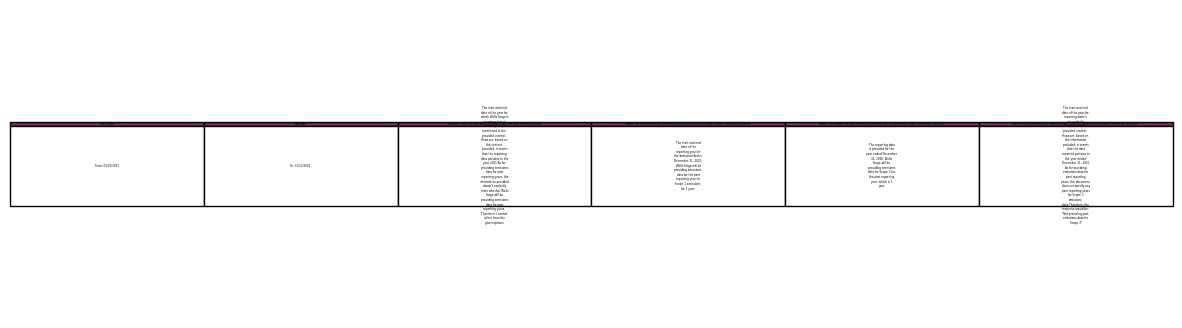

In [80]:
import pandas as pd
import numpy as np
import matplotlib.for i in substrings:
                    page.insert_text((50, y_coordinate), f"{i}")  
                    y_coordinate += 20  # Move to the next line
                pyplot as plt

df = pd.read_csv('C0.2.csv')
df = df.replace('\n', '', regex=True)
# df = pd.DataFrame(np.random.randn(20, 2), columns=['First', 'Second'])
# Maximum number of words before wrapping
max_words = 20

# Function to wrap text to a maximum number of words
def wrap_text(text):
    return '\n'.join(wrap(text, width=max_words))  # Wrap text to a maximum of 10 words

# Apply word wrapping to each cell in the DataFrame including headers
df = df.applymap(lambda x: wrap_text(x) if isinstance(x, str) else x)


ig, ax = plt.subplots(figsize=(15, 4))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df.values,
                colLabels=df.columns,
                cellLoc='center',
                colColours=['#82246f']*len(df.columns),  # Header color
                loc='center',
                fontsize=20,
                bbox=[0, 0, 1, 1])  # Adjust font size as needed

cellDict = table.get_celld()
for i, row in enumerate(df.values):
    max_lines = max(len(str(cell).split('\n')) for cell in row)
    for j in range(len(df.columns)):
        cellDict[i+1, j]._height = max_lines * 0.01  # Adjust the multiplier as needed for appropriate row height

# Adjust header row heights based on the maximum height of content
header_max_lines = max(len(str(label).split('\n')) for label in df.columns)
for j in range(len(df.columns)):
    cellDict[0, j]._height = header_max_lines * 0.01  # Adjust the multiplier as needed for appropriate row height

plt.show()

In [25]:
df.to_csv("new_df.csv", index=False)

/tmp/ipykernel_14124/2613015156.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: wrap_text(x) if isinstance(x, str) else x)


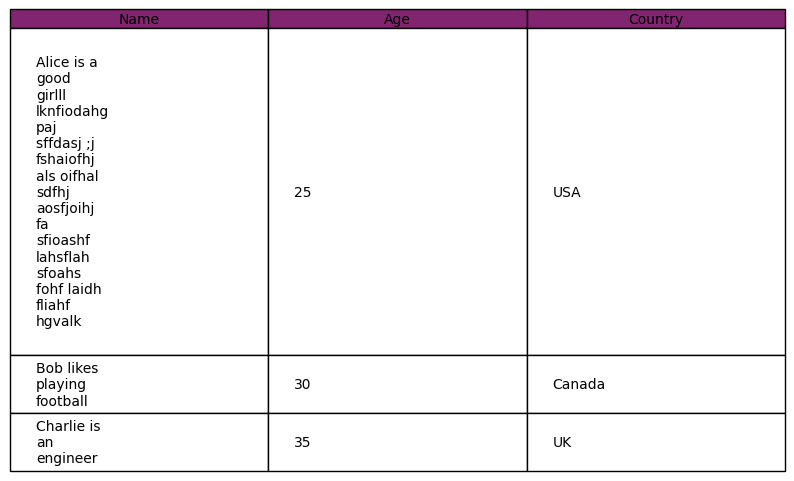

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
from textwrap import wrap

# Sample DataFrame
data = {'Name': ['Alice is a good girlll lknfiodahg paj sffdasj ;j fshaiofhj als oifhalsdfhj aosfjoihj fa sfioashf lahsflah sfoahs fohf laidh fliahf hgvalk', 'Bob likes playing football', 'Charlie is an engineer'],
        'Age': [25, 30, 35],
        'Country': ['USA', 'Canada', 'UK']}

df = pd.DataFrame(data)

# Maximum number of words before wrapping
max_words = 10

# Function to wrap text to a maximum number of words
def wrap_text(text):
    return '\n'.join(wrap(text, width=max_words))  # Wrap text to a maximum of 10 words

# Apply word wrapping to each cell in the DataFrame including headers
df = df.applymap(lambda x: wrap_text(x) if isinstance(x, str) else x)

fig, ax = plt.subplots(figsize=(10, 5))
ax.axis('tight')
ax.axis('off')

# Create the table with dynamic size adjustment and text wrapping
table = ax.table(cellText=df.values,
                 colLabels=df.columns,
                 cellLoc='left',  # Set to 'left' for text wrapping
                 colColours=['#82246f']*len(df.columns),  # Header color
                 loc='center',
                 fontsize=12)  # Adjust the font size as needed

# Adjust row heights based on the maximum height of content in each row including headers
cellDict = table.get_celld()
for i, row in enumerate(df.values):
    max_lines = max(len(str(cell).split('\n')) for cell in row)
    for j in range(len(df.columns)):
        cellDict[i+1, j]._height = max_lines * 0.05  # Adjust the multiplier as needed for appropriate row height

# Adjust header row heights based on the maximum height of content
header_max_lines = max(len(str(label).split('\n')) for label in df.columns)
for j in range(len(df.columns)):
    cellDict[0, j]._height = header_max_lines * 0.05  # Adjust the multiplier as needed for appropriate row height

plt.show()

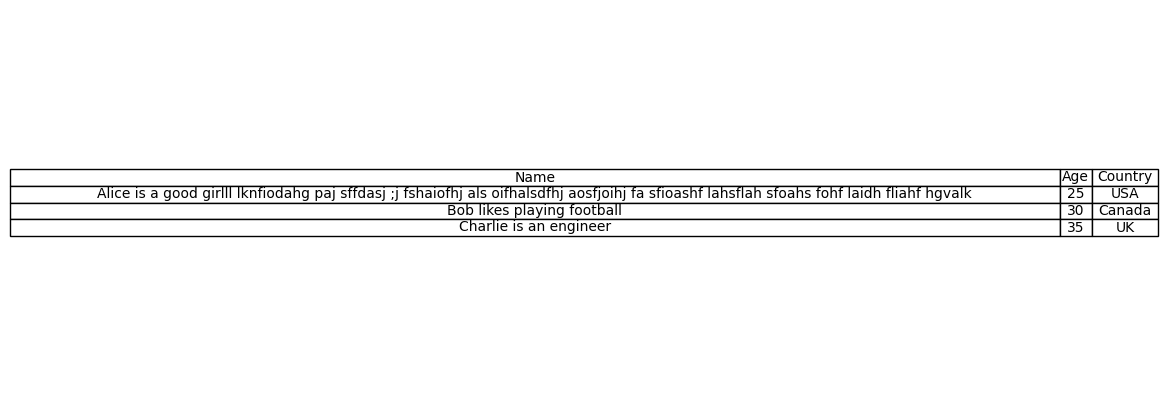

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample DataFrame
data = {'Name': ['Alice is a good girlll lknfiodahg paj sffdasj ;j fshaiofhj als oifhalsdfhj aosfjoihj fa sfioashf lahsflah sfoahs fohf laidh fliahf hgvalk', 'Bob likes playing football', 'Charlie is an engineer'],
        'Age': [25, 30, 35],
        'Country': ['USA', 'Canada', 'UK']}

df = pd.DataFrame(data)

# Calculate maximum width for each column
max_widths = [df[col].astype(str).apply(lambda x: len(x)).max() for col in df.columns]

fig, ax = plt.subplots(figsize=(10, 5))
ax.axis('tight')
ax.axis('off')

# Create the table
table = ax.table(cellText=df.values,
                 colLabels=df.columns,
                 cellLoc='center',
                 loc='center')

# Adjust column widths
for i, width in enumerate(max_widths):
    table.auto_set_column_width(i)

plt.show()

/tmp/ipykernel_14124/3182281575.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_wrapped = df.applymap(lambda x: wrap_text(x) if isinstance(x, str) else x)


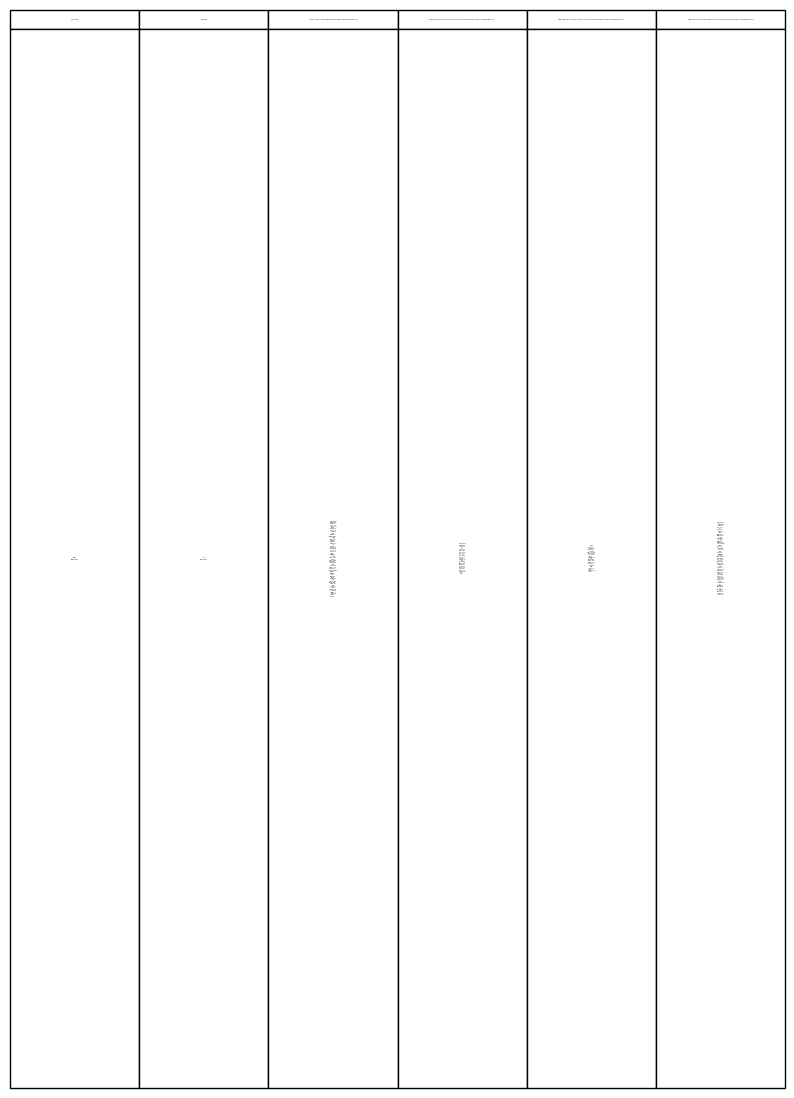

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
from textwrap import wrap

# Sample DataFrame
# data = {'Name': ['Alice is a good girlll lknfiodahg paj sffdasj ;j fshaiofhj als oifhalsdfhj aosfjoihj fa sfioashf lahsflah sfoahs fohf laidh fliahf hgvalk', 'Bob likes playing football', 'Charlie is an engineer'],
#         'Age': [25, 30, 35],
#         'Country': ['USA', 'Canada', 'UK']}

# df = pd.DataFrame(data)
df = pd.read_csv("C0.2.csv")

# Maximum number of words before wrapping
max_words = 10

# Function to wrap text to a maximum number of words
def wrap_text(text):
    return '\n'.join(wrap(text, width=max_words))  # Wrap text to a maximum of 10 words

# Apply word wrapping to each cell in the DataFrame including headers
df_wrapped = df.applymap(lambda x: wrap_text(x) if isinstance(x, str) else x)

fig, ax = plt.subplots(figsize=(10, 5))
ax.axis('tight')
ax.axis('off')

# Create the table including headers
table = ax.table(cellText=df_wrapped.values,
                 colLabels=df.columns,
                 cellLoc='center',
                 loc='center')

# Adjust row heights based on the maximum height of content in each row including headers
cellDict = table.get_celld()
for i, row in enumerate(df_wrapped.values):
    max_lines = max(len(str(cell).split('\n')) for cell in row)
    for j in range(len(df_wrapped.columns)):
        cellDict[i+1, j]._height = max_lines * 0.05  # Adjust the multiplier as needed for appropriate row height

# Adjust header row heights based on the maximum height of content
header_max_lines = max(len(str(label).split('\n')) for label in df_wrapped.columns)
for j in range(len(df_wrapped.columns)):
    cellDict[0, j]._height = header_max_lines * 0.05  # Adjust the multiplier as needed for appropriate row height

plt.show()

In [64]:
df_wrapped.values

array([['Alice is a\ngood\ngirlll\nlknfiodahg\npaj\nsffdasj ;j\nfshaiofhj\nals oifhal\nsdfhj\naosfjoihj\nfa\nsfioashf\nlahsflah\nsfoahs\nfohf laidh\nfliahf\nhgvalk',
        25, 'USA'],
       ['Bob likes\nplaying\nfootball', 30, 'Canada'],
       ['Charlie is\nan\nengineer', 35, 'UK']], dtype=object)